# Statistical inference of stock returns with linear regression

## Imports & Settings

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline
import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load Data

In [6]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

### Select Investment Universe

In [7]:
data = data[data.dollar_vol_rank<100]

### Create Model Data

In [8]:
y = data.filter(like='target') # get the y values to predict on
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

## Explore Data

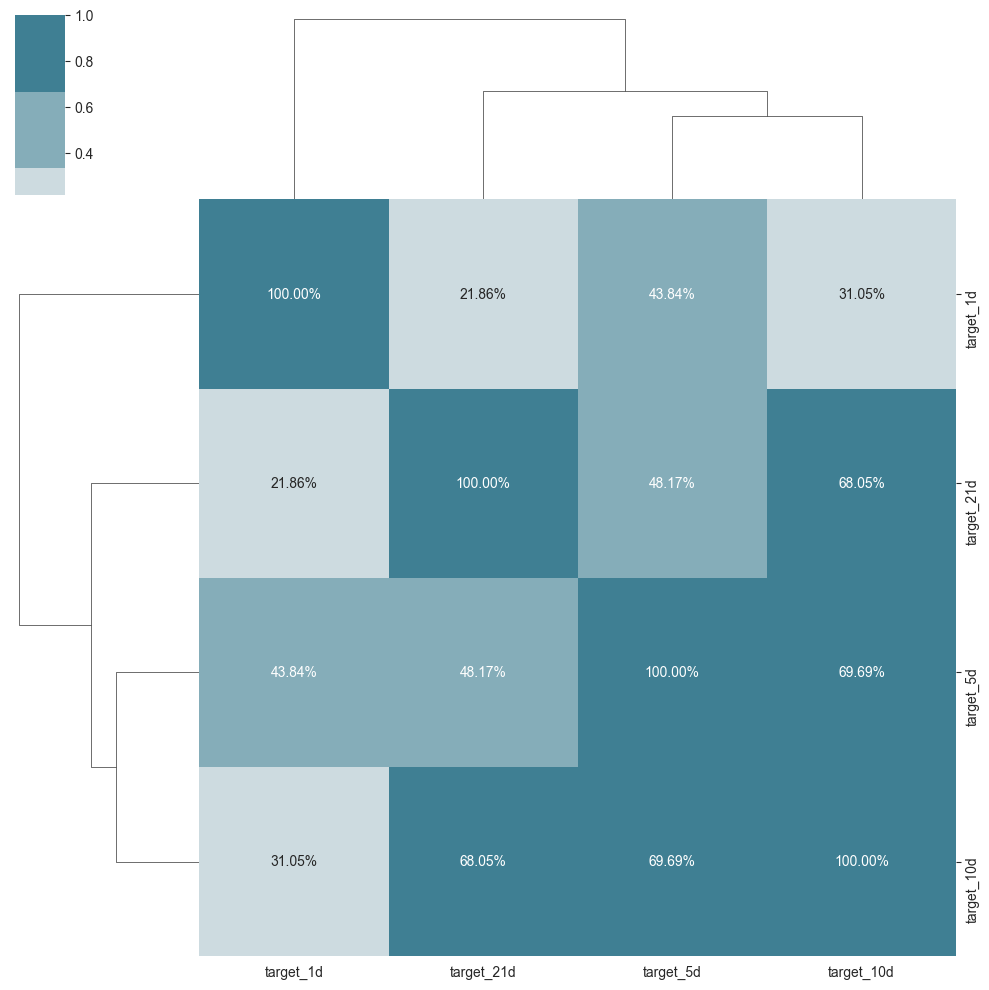

In [9]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');

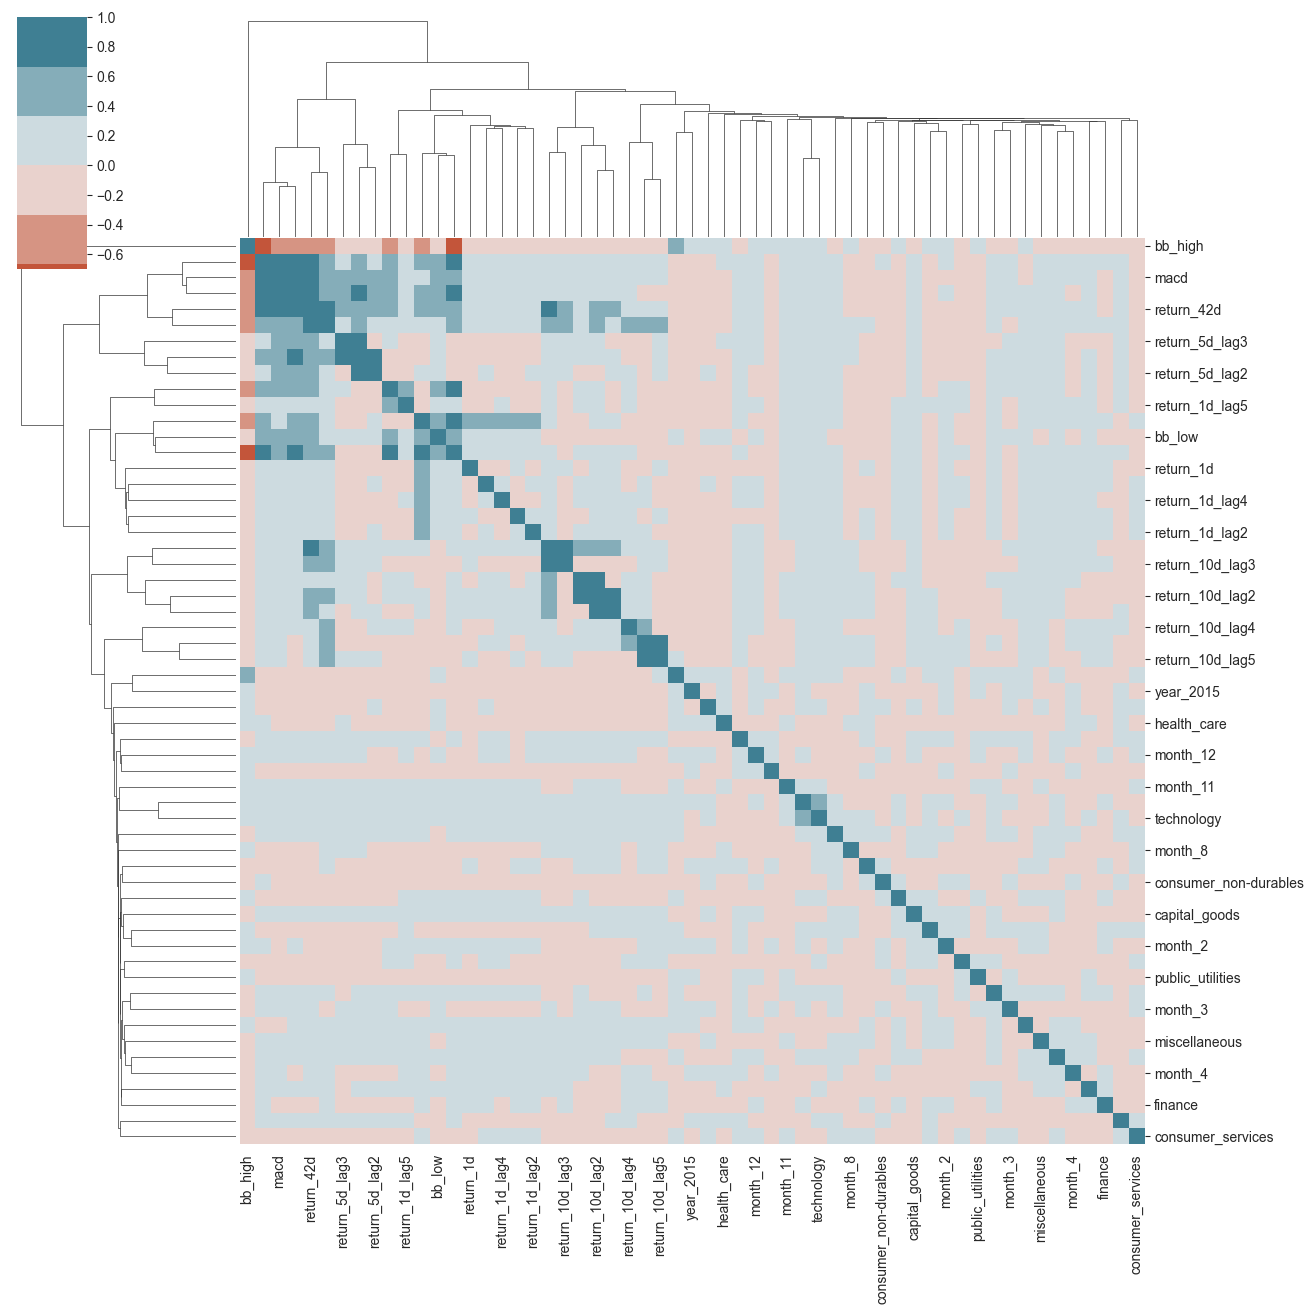

In [10]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

In [11]:
X

dollar_vol_1m        rsi   bb_high    bb_low       atr  \
ticker date                                                                 
AAL    2013-07-25  223614.661574  69.669475  0.011251  0.140777 -0.383445   
       2013-07-26  234821.351626  72.045207  0.007052  0.146370 -0.412740   
       2013-07-29  243001.954091  73.259776  0.008843  0.146963 -0.494894   
       2013-07-30  243122.621493  72.532538  0.018500  0.142355 -0.565684   
       2013-07-31  256336.659780  73.926238  0.016465  0.139949 -0.653399   
...                          ...        ...       ...       ...       ...   
ZTS    2014-11-28  294715.115434  71.884144  0.043559  0.157493  0.397024   
       2014-12-01  297525.671580  67.137279  0.051976  0.131103  0.403122   
       2014-12-02  298272.515355  68.612084  0.041573  0.120638  0.323857   
       2014-12-03  295315.035852  69.175766  0.038192  0.111125  0.236555   
       2014-12-04  286390.276661  61.677853  0.051743  0.080568  0.273293   

                       macd  return_1d  return_5d  return_10d  return_21d  \
ticker date                                                                 
AAL    2013-07-25  0.681257   0.017838   0.004413    0.008103    0.006426   
       2013-07-26  0.772848   0.013808   0.009262    0.008389    0.007936   
       2013-07-29  0.854980   0.007334   0.011627    0.007984    0.007873   
       2013-07-30  0.904814  -0.001560   0.012430    0.006755    0.007476   
       2013-07-31  0.954135   0.007813   0.009025    0.004774    0.006752   
...                     ...        ...        ...         ...         ...   
ZTS    2014-11-28  2.806829   0.005820   0.008117    0.003841    0.009878   
       2014-12-01  2.691178  -0.012464   0.002269    0.002815    0.008365   
       2014-12-02  2.615256   0.008339   0.000717    0.001147    0.009064   
       2014-12-03  2.540352   0.003129   0.004380    0.001551    0.008311   
       2014-12-04  2.329735  -0.019608  -0.003018    0.001374    0.005614   

                   ...  capital_goods  consumer_non-durables  \
ticker date        ...                                         
AAL    2013-07-25  ...          False                  False   
       2013-07-26  ...          False                  False   
       2013-07-29  ...          False                  False   
       2013-07-30  ...          False                  False   
       2013-07-31  ...          False                  False   
...                ...            ...                    ...   
ZTS    2014-11-28  ...          False                  False   
       2014-12-01  ...          False                  False   
       2014-12-02  ...          False                  False   
       2014-12-03  ...          False                  False   
       2014-12-04  ...          False                  False   

                   consumer_services  energy  finance  health_care  \
ticker date                                                          
AAL    2013-07-25              False   False    False        False   
       2013-07-26              False   False    False        False   
       2013-07-29              False   False    False        False   
       2013-07-30              False   False    False        False   
       2013-07-31              False   False    False        False   
...                              ...     ...      ...          ...   
ZTS    2014-11-28              False   False    False         True   
       2014-12-01              False   False    False         True   
       2014-12-02              False   False    False         True   
       2014-12-03              False   False    False         True   
       2014-12-04              False   False    False         True   

                   miscellaneous  public_utilities  technology  transportation  
ticker date                                                                     
AAL    2013-07-25          False             False       False            True  
       2013-07-26          F

In [12]:
X.corr()

,dollar_vol_1m,rsi,bb_high,bb_low,atr,macd,return_1d,return_5d,return_10d,return_21d,...,capital_goods,consumer_non-durables,consumer_services,energy,finance,health_care,miscellaneous,public_utilities,technology,transportation
dollar_vol_1m,1.000000,0.030572,0.013085,0.043684,0.090698,0.000702,0.006626,0.011494,0.014060,0.019098,...,-0.038505,-0.092622,-0.013286,-0.066391,0.031697,-0.106351,-0.048175,-0.009616,0.332774,-0.087663
rsi,0.030572,1.000000,-0.696555,0.575231,-0.169038,0.817113,0.302014,0.594965,0.722691,0.759128,...,0.018249,0.005727,-0.008349,-0.066107,0.009357,-0.000603,0.033172,-0.030682,0.052029,-0.005444
bb_high,0.013085,-0.696555,1.000000,-0.093241,0.359661,-0.559794,-0.284125,-0.580094,-0.693640,-0.632777,...,-0.019439,-0.065282,-0.001110,0.051276,-0.040348,0.010218,-0.039201,0.003264,0.003468,0.030977
bb_low,0.043684,0.575231,-0.093241,1.000000,0.177661,0.425135,0.281458,0.547511,0.634893,0.524501,...,0.001376,-0.071540,-0.008024,-0.000968,-0.040538,0.001025,-0.020486,-0.028502,0.066794,0.035013
atr,0.090698,-0.169038,0.359661,0.177661,1.000000,-0.170858,-0.015376,-0.071725,-0.109513,-0.145273,...,-0.022416,-0.001486,0.018311,-0.002729,-0.041058,0.001594,-0.014514,0.015128,0.016295,0.008624
macd,0.000702,0.817113,-0.559794,0.425135,-0.170858,1.000000,0.045311,0.293732,0.552249,0.793893,...,0.009141,-0.001119,-0.027677,-0.009128,-0.010723,-0.001685,0.005658,-0.014290,0.044018,-0.005841
return_1d,0.006626,0.302014,-0.284125,0.281458,-0.015376,0.045311,1.000000,0.419707,0.290246,0.192846,...,0.003509,-0.001063,-0.001080,-0.009343,0.002032,-0.002930,0.003290,-0.004391,0.009720,0.003072
return_5d,0.011494,0.594965,-0.580094,0.547511,-0.071725,0.293732,0.419707,1.000000,0.685910,0.457613,...,0.009473,-0.002028,-0.000039,-0.020702,0.003117,-0.006751,0.007786,-0.009637,0.023208,0.001126
return_10d,0.014060,0.722691,-0.693640,0.634893,-0.109513,0.552249,0.290246,0.685910,1.000000,0.668797,...,0.013479,-0.002696,-0.002905,-0.026547,0.001941,-0.007374,0.011005,-0.016338,0.033820,0.000052
return_21d,0.019098,0.759128,-0.632777,0.524501,-0.145273,0.793893,0.192846,0.457613,0.668797,1.000000,...,0.013903,-0.003014,-0.013764,-0.033288,-0.003103,-0.004368,0.015782,-0.028376,0.050376,0.000902


In [13]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)

In [14]:
corr_mat[corr_mat["var1"] == "return_42d"]

,var1,var2,corr
581,return_42d,return_63d,0.835634
575,return_42d,macd,0.767963
579,return_42d,return_21d,0.748812
585,return_42d,return_21d_lag1,0.681295
571,return_42d,rsi,0.666964
584,return_42d,return_10d_lag1,0.524309
578,return_42d,return_10d,0.497197
588,return_42d,return_10d_lag2,0.484324
592,return_42d,return_10d_lag3,0.456783
591,return_42d,return_5d_lag3,0.372824


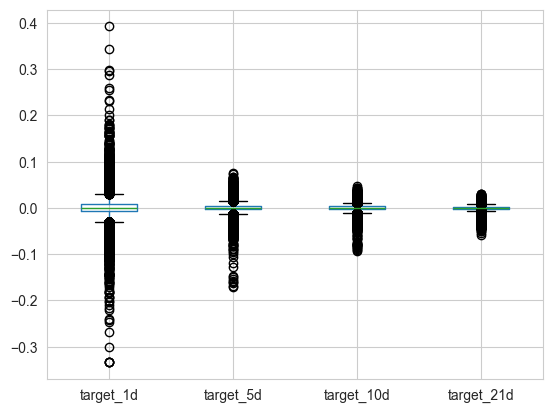

In [15]:
y.boxplot();

## Linear Regression for Statistical Inference: OLS with statsmodels

### Ticker-wise standardization

`statsmodels` warns of high design matrix condition numbers. This can arise when the variables are not standardized and the Eigenvalues differ due to scaling. The following step avoids this warning.

design matrix is bascially your feature matrix

condition number is largest singular value / smallest singular value, high condition number results from multicollinearity, maotrix close to singular, small changes in data, big changes in coefficients 

In [16]:
sectors = X.iloc[:, -10:]
sectors

capital_goods  consumer_non-durables  consumer_services  \
ticker date                                                                  
AAL    2013-07-25          False                  False              False   
       2013-07-26          False                  False              False   
       2013-07-29          False                  False              False   
       2013-07-30          False                  False              False   
       2013-07-31          False                  False              False   
...                          ...                    ...                ...   
ZTS    2014-11-28          False                  False              False   
       2014-12-01          False                  False              False   
       2014-12-02          False                  False              False   
       2014-12-03          False                  False              False   
       2014-12-04          False                  False              False   

                   energy  finance  health_care  miscellaneous  \
ticker date                                                      
AAL    2013-07-25   False    False        False          False   
       2013-07-26   False    False        False          False   
       2013-07-29   False    False        False          False   
       2013-07-30   False    False        False          False   
       2013-07-31   False    False        False          False   
...                   ...      ...          ...            ...   
ZTS    2014-11-28   False    False         True          False   
       2014-12-01   False    False         True          False   
       2014-12-02   False    False         True          False   
       2014-12-03   False    False         True          False   
       2014-12-04   False    False         True          False   

                   public_utilities  technology  transportation  
ticker date                                                      
AAL    2013-07-25             False       False            True  
       2013-07-26             False       False            True  
       2013-07-29             False       False            True  
       2013-07-30             False       False            True  
       2013-07-31             False       False            True  
...                             ...         ...             ...  
ZTS    2014-11-28             False       False           False  
       2014-12-01             False       False           False  
       2014-12-02             False       False           False  
       2014-12-03             False       False           False  
       2014-12-04             False       False           False  

[109675 rows x 10 columns]

In [17]:
sectors = X.iloc[:, -10:]
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='ticker')
     .transform(lambda x: (x - x.mean()) / x.std())
    .join(sectors)
    .fillna(0))

### 1-Day Returns

In [18]:
print(X.dtypes)
print(y[target].dtype)


dollar_vol_1m            float64
rsi                      float64
bb_high                  float64
bb_low                   float64
atr                      float64
macd                     float64
return_1d                float64
return_5d                float64
return_10d               float64
return_21d               float64
return_42d               float64
return_63d               float64
return_1d_lag1           float64
return_5d_lag1           float64
return_10d_lag1          float64
return_21d_lag1          float64
return_1d_lag2           float64
return_5d_lag2           float64
return_10d_lag2          float64
return_21d_lag2          float64
return_1d_lag3           float64
return_5d_lag3           float64
return_10d_lag3          float64
return_21d_lag3          float64
return_1d_lag4           float64
return_5d_lag4           float64
return_10d_lag4          float64
return_21d_lag4          float64
return_1d_lag5           float64
return_5d_lag5           float64
return_10d

NameError: name 'target' is not defined

In [ ]:
X

dollar_vol_1m       rsi   bb_high    bb_low       atr  \
ticker date                                                                
AAL    2013-07-25      -1.377498  1.427605 -0.773214  0.535185 -0.461161   
       2013-07-26      -1.308351  1.606301 -0.824760  0.589545 -0.487341   
       2013-07-29      -1.257876  1.697656 -0.802774  0.595311 -0.560761   
       2013-07-30      -1.257131  1.642956 -0.684236  0.550522 -0.624026   
       2013-07-31      -1.175599  1.747786 -0.709213  0.527137 -0.702416   
...                          ...       ...       ...       ...       ...   
ZTS    2014-11-28       0.482447  0.789549 -0.697431  0.231390 -0.457231   
       2014-12-01       0.925568 -0.628407  0.432822 -0.492799 -0.419505   
       2014-12-02       1.043318 -0.187862 -0.963998 -0.779983 -0.909876   
       2014-12-03       0.577032 -0.019482 -1.418054 -1.041020 -1.449963   
       2014-12-04      -0.830073 -2.259217  0.401583 -1.879585 -1.222688   

                       macd  return_1d  return_5d  return_10d  return_21d  \
ticker date                                                                 
AAL    2013-07-25  0.702504   0.639313   0.267036    0.686683    0.794435   
       2013-07-26  0.784250   0.486606   0.559203    0.710383    0.975378   
       2013-07-29  0.857554   0.241291   0.701721    0.676785    0.967823   
       2013-07-30  0.902031  -0.095710   0.750056    0.574837    0.920204   
       2013-07-31  0.946050   0.259434   0.544923    0.410579    0.833460   
...                     ...        ...        ...         ...         ...   
ZTS    2014-11-28  0.456081   0.314405   1.766856   -0.136877    0.987851   
       2014-12-01 -0.181351  -1.004132   0.035205   -0.420698   -0.283072   
       2014-12-02 -0.599807   0.496023  -0.424441   -0.882110    0.303774   
       2014-12-03 -1.012653   0.120329   0.660102   -0.770513   -0.329040   
       2014-12-04 -2.173507  -1.519309  -1.530273   -0.819365   -2.595182   

                   ...  capital_goods  consumer_non-durables  \
ticker date        ...                                         
AAL    2013-07-25  ...          False                  False   
       2013-07-26  ...          False                  False   
       2013-07-29  ...          False                  False   
       2013-07-30  ...          False                  False   
       2013-07-31  ...          False                  False   
...                ...            ...                    ...   
ZTS    2014-11-28  ...          False                  False   
       2014-12-01  ...          False                  False   
       2014-12-02  ...          False                  False   
       2014-12-03  ...          False                  False   
       2014-12-04  ...          False                  False   

                   consumer_services  energy  finance  health_care  \
ticker date                                                          
AAL    2013-07-25              False   False    False        False   
       2013-07-26              False   False    False        False   
       2013-07-29              False   False    False        False   
       2013-07-30              False   False    False        False   
       2013-07-31              False   False    False        False   
...                              ...     ...      ...          ...   
ZTS    2014-11-28              False   False    False         True   
       2014-12-01              False   False    False         True   
       2014-12-02              False   False    False         True   
       2014-12-03              False   False    False         True   
       2014-12-04              False   False    False         True   

                   miscellaneous  public_utilities  technology  transportation  
ticker date                                                                     
AAL    2013-07-25          False             False       False            True  
       2013-07-26          False         

In [21]:
y["target_1d"]

ticker  date      
AAL     2013-07-25    0.013808
        2013-07-26    0.007334
        2013-07-29   -0.001560
        2013-07-30    0.007813
        2013-07-31    0.001550
                        ...   
ZTS     2014-11-28   -0.012464
        2014-12-01    0.008339
        2014-12-02    0.003129
        2014-12-03   -0.019608
        2014-12-04   -0.000455
Name: target_1d, Length: 109675, dtype: float64

In [29]:
X = X.astype({col: "int" for col in X.select_dtypes("bool").columns})

target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     19.03
Date:                Fri, 21 Nov 2025   Prob (F-statistic):          9.43e-189
Time:                        16:38:02   Log-Likelihood:             2.8852e+05
No. Observations:              109675   AIC:                        -5.769e+05
Df Residuals:                  109617   BIC:                        -5.764e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### 5-Day Returns

In [30]:
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     61.86
Date:                Fri, 21 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:38:06   Log-Likelihood:             3.7883e+05
No. Observations:              109675   AIC:                        -7.575e+05
Df Residuals:                  109617   BIC:                        -7.570e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

#### Obtain the residuals

In [33]:
y[target]

ticker  date      
AAL     2013-07-25    0.005775
        2013-07-26   -0.001787
        2013-07-29   -0.000625
        2013-07-30   -0.002934
        2013-07-31   -0.005011
                        ...   
ZTS     2014-11-28   -0.004265
        2014-12-01   -0.001220
        2014-12-02   -0.004147
        2014-12-03   -0.009585
        2014-12-04   -0.005144
Name: target_5d, Length: 109675, dtype: float64

In [31]:
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


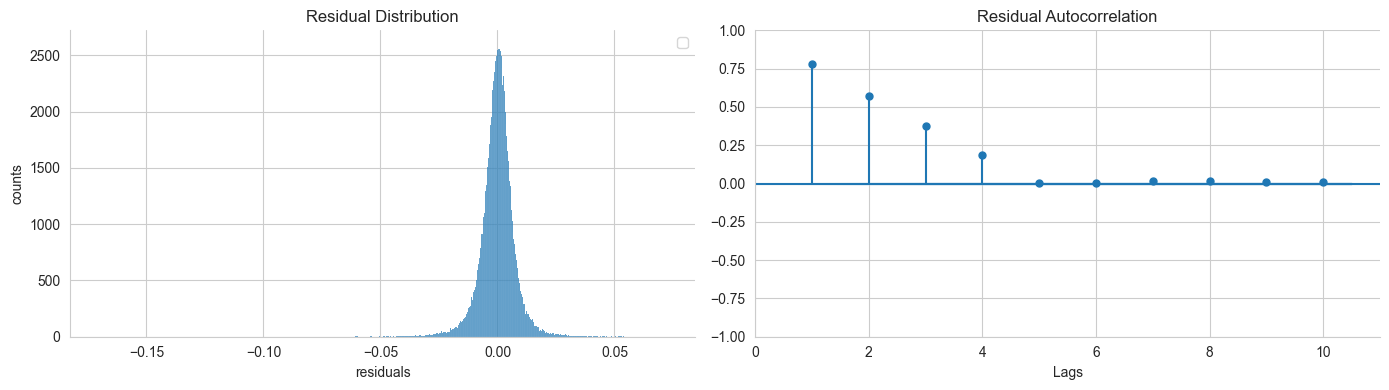

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.histplot(residuals, ax=axes[0])
axes[0].set_title('Residual Distribution')
axes[0].legend()
axes[0].set_xlabel("residuals")
axes[0].set_ylabel("counts")
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();

### 10-Day Returns

In [18]:
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     85.38
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:03:18   Log-Likelihood:             4.1892e+05
No. Observations:              109675   AIC:                        -8.377e+05
Df Residuals:                  109617   BIC:                        -8.372e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### Monthly Returns

In [19]:
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     119.7
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:03:18   Log-Likelihood:             4.6155e+05
No. Observations:              109675   AIC:                        -9.230e+05
Df Residuals:                  109617   BIC:                        -9.224e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00